In [ ]:
!pip install torch torchvision
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 28*28)  # Output size for MNIST
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))  # Output values between -1 and 1
        return x.view(x.size(0), 1, 28, 28)  # Reshape to image size (1x28x28)


In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return self.fc4(x)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)


In [ ]:
def compute_gradient_penalty(critic, real_images, fake_images, device):
    batch_size, C, H, W = real_images.size()
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    critic_outputs = critic(interpolated_images)
    gradients = torch.autograd.grad(
        outputs=critic_outputs, inputs=interpolated_images,
        grad_outputs=torch.ones_like(critic_outputs),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()

    return penalty


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/100], Generator Loss: -1.019765853881836, Critic Loss: -9.882560729980469


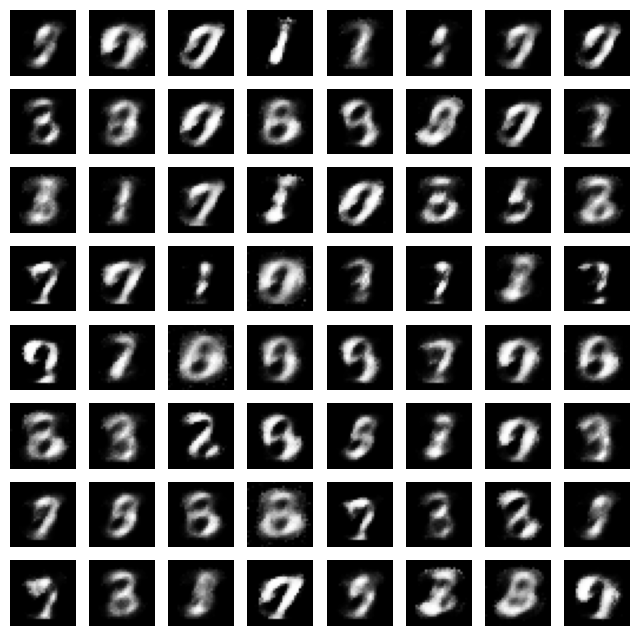

Epoch [1/100], Generator Loss: 5.4776611328125, Critic Loss: -8.540847778320312
Epoch [2/100], Generator Loss: 7.09343147277832, Critic Loss: -8.504049301147461
Epoch [3/100], Generator Loss: 6.175593376159668, Critic Loss: -8.739261627197266
Epoch [4/100], Generator Loss: 4.148018836975098, Critic Loss: -7.647930145263672
Epoch [5/100], Generator Loss: 3.319304943084717, Critic Loss: -8.139959335327148
Epoch [6/100], Generator Loss: 3.175846576690674, Critic Loss: -6.106094837188721
Epoch [7/100], Generator Loss: 3.6879045963287354, Critic Loss: -6.474423885345459
Epoch [8/100], Generator Loss: 3.13859486579895, Critic Loss: -6.440837860107422
Epoch [9/100], Generator Loss: 2.6501219272613525, Critic Loss: -5.240971088409424
Epoch [10/100], Generator Loss: 1.8829224109649658, Critic Loss: -5.718100070953369


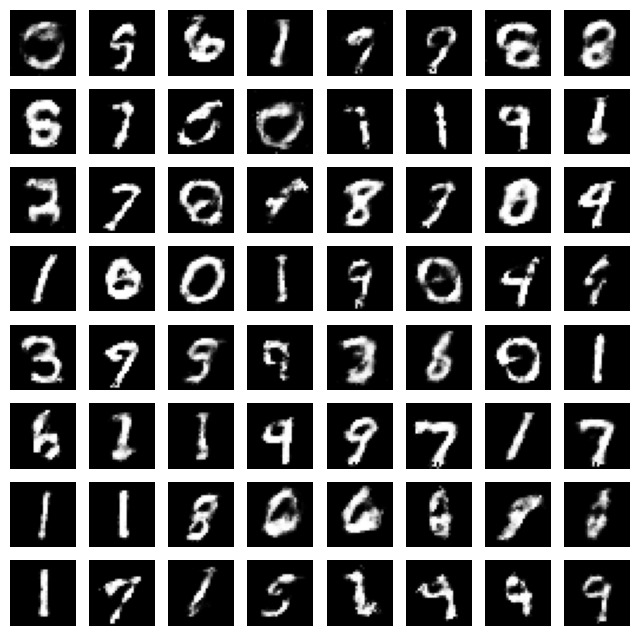

Epoch [11/100], Generator Loss: 3.1316795349121094, Critic Loss: -5.695021629333496
Epoch [12/100], Generator Loss: 3.786287784576416, Critic Loss: -5.5495100021362305
Epoch [13/100], Generator Loss: 2.2174320220947266, Critic Loss: -6.2070441246032715
Epoch [14/100], Generator Loss: 2.02592134475708, Critic Loss: -5.388365745544434
Epoch [15/100], Generator Loss: 2.5628936290740967, Critic Loss: -5.01171875
Epoch [16/100], Generator Loss: 3.417017936706543, Critic Loss: -5.435652732849121
Epoch [17/100], Generator Loss: 2.6321523189544678, Critic Loss: -5.237242221832275
Epoch [18/100], Generator Loss: 0.8441393375396729, Critic Loss: -4.844494819641113
Epoch [19/100], Generator Loss: 2.813830614089966, Critic Loss: -4.260962009429932
Epoch [20/100], Generator Loss: 2.8059792518615723, Critic Loss: -4.0572123527526855


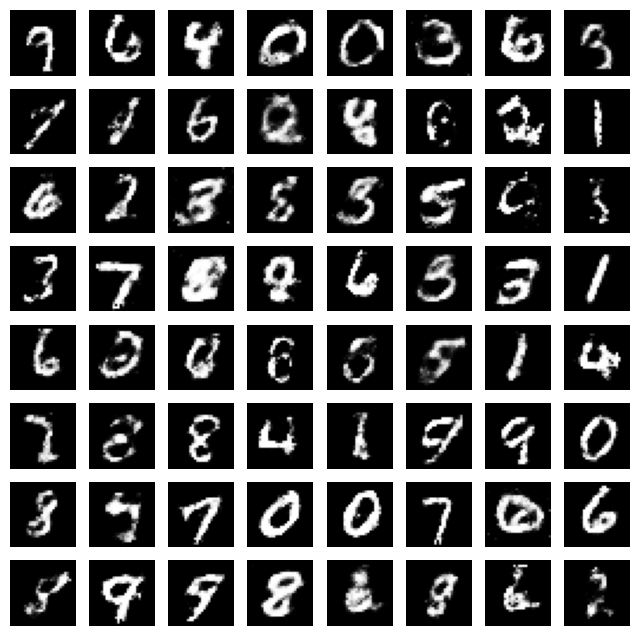

Epoch [21/100], Generator Loss: 0.7759565114974976, Critic Loss: -4.894758701324463
Epoch [22/100], Generator Loss: 1.8529194593429565, Critic Loss: -4.008973598480225
Epoch [23/100], Generator Loss: 2.466503143310547, Critic Loss: -4.413649559020996
Epoch [24/100], Generator Loss: 4.3302154541015625, Critic Loss: -3.985353946685791
Epoch [25/100], Generator Loss: 2.3065662384033203, Critic Loss: -3.937465190887451
Epoch [26/100], Generator Loss: 1.4116153717041016, Critic Loss: -3.7284111976623535
Epoch [27/100], Generator Loss: 1.5815163850784302, Critic Loss: -3.3518764972686768
Epoch [28/100], Generator Loss: 2.4167659282684326, Critic Loss: -3.4295554161071777
Epoch [29/100], Generator Loss: 3.3684988021850586, Critic Loss: -3.482732057571411
Epoch [30/100], Generator Loss: 2.411480665206909, Critic Loss: -4.131822109222412


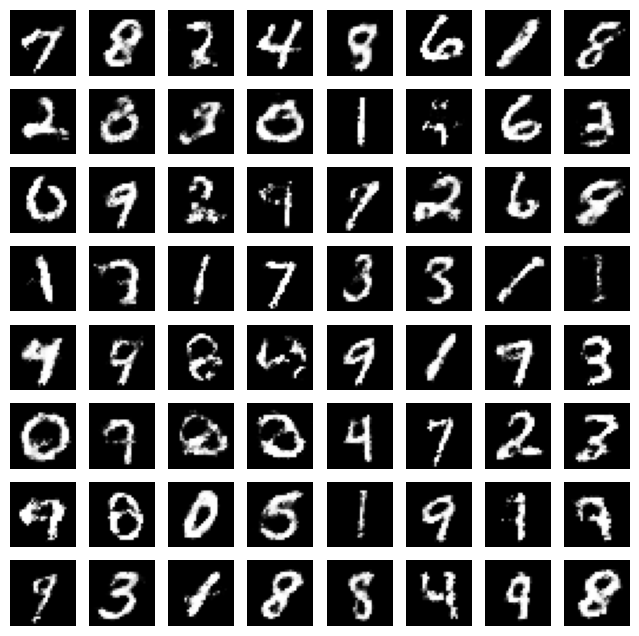

Epoch [31/100], Generator Loss: 3.122720956802368, Critic Loss: -4.4185919761657715
Epoch [32/100], Generator Loss: 1.932576298713684, Critic Loss: -3.2120089530944824
Epoch [33/100], Generator Loss: 3.9149010181427, Critic Loss: -4.1192626953125
Epoch [34/100], Generator Loss: 1.9456405639648438, Critic Loss: -3.450266122817993
Epoch [35/100], Generator Loss: 2.337827205657959, Critic Loss: -4.028926849365234
Epoch [36/100], Generator Loss: 2.337876796722412, Critic Loss: -3.641749620437622
Epoch [37/100], Generator Loss: 2.076479911804199, Critic Loss: -3.5958504676818848
Epoch [38/100], Generator Loss: 1.7122738361358643, Critic Loss: -4.8510637283325195
Epoch [39/100], Generator Loss: 1.944890022277832, Critic Loss: -4.222657680511475
Epoch [40/100], Generator Loss: 2.106802463531494, Critic Loss: -3.0691890716552734


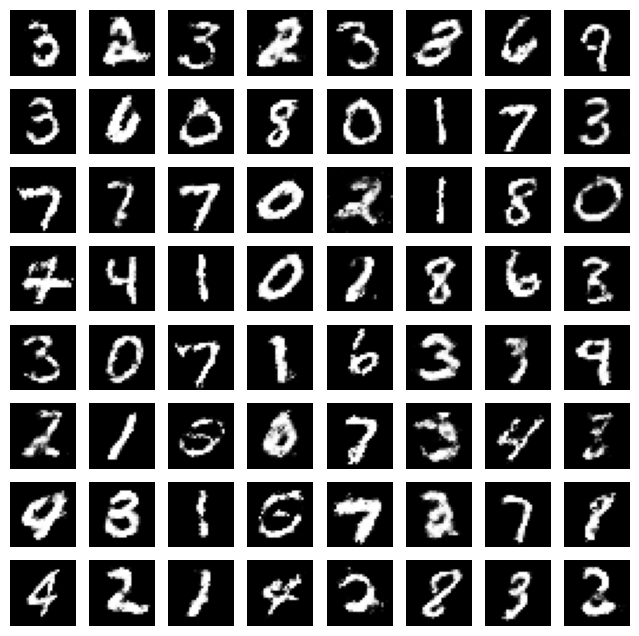

Epoch [41/100], Generator Loss: 1.8847846984863281, Critic Loss: -3.0577855110168457
Epoch [42/100], Generator Loss: 1.8216280937194824, Critic Loss: -2.9610073566436768
Epoch [43/100], Generator Loss: 1.6484317779541016, Critic Loss: -3.1634323596954346
Epoch [44/100], Generator Loss: 2.2553231716156006, Critic Loss: -3.8224620819091797
Epoch [45/100], Generator Loss: 1.7969690561294556, Critic Loss: -2.929837226867676
Epoch [46/100], Generator Loss: 1.4023828506469727, Critic Loss: -3.4849750995635986
Epoch [47/100], Generator Loss: 3.990438938140869, Critic Loss: -3.610124111175537
Epoch [48/100], Generator Loss: 2.6807198524475098, Critic Loss: -4.024571895599365
Epoch [49/100], Generator Loss: 4.275356292724609, Critic Loss: -3.731088638305664
Epoch [50/100], Generator Loss: 2.9619622230529785, Critic Loss: -2.4424057006835938


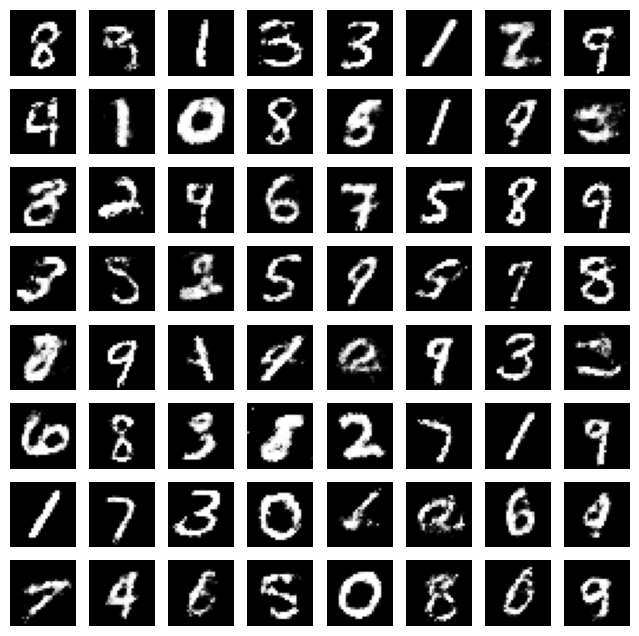

Epoch [51/100], Generator Loss: 3.349721908569336, Critic Loss: -3.1948132514953613
Epoch [52/100], Generator Loss: 2.274275779724121, Critic Loss: -2.818593740463257
Epoch [53/100], Generator Loss: 2.9365932941436768, Critic Loss: -2.3983798027038574
Epoch [54/100], Generator Loss: 1.3479989767074585, Critic Loss: -2.847768783569336
Epoch [55/100], Generator Loss: -0.31626957654953003, Critic Loss: -3.0087645053863525
Epoch [56/100], Generator Loss: 4.2217841148376465, Critic Loss: -2.9516093730926514
Epoch [57/100], Generator Loss: 3.8436591625213623, Critic Loss: -3.7720258235931396
Epoch [58/100], Generator Loss: 3.0433788299560547, Critic Loss: -2.9971156120300293
Epoch [59/100], Generator Loss: 3.48055100440979, Critic Loss: -2.856598377227783
Epoch [60/100], Generator Loss: 1.313772439956665, Critic Loss: -3.295668840408325


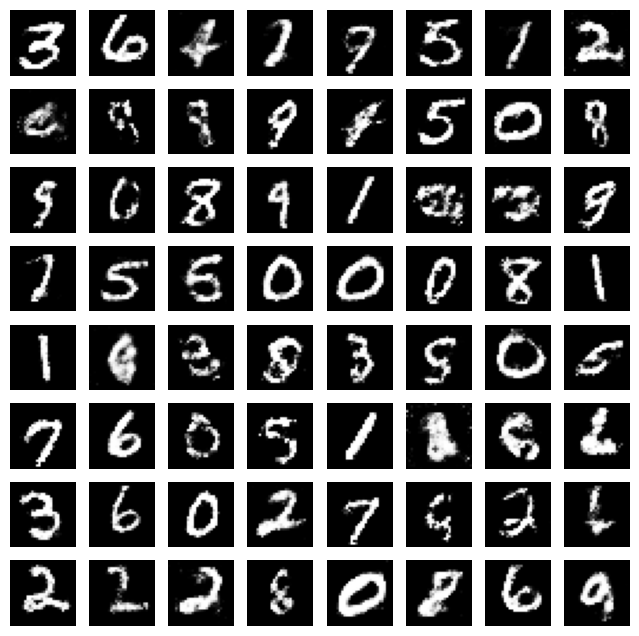

Epoch [61/100], Generator Loss: 3.179497241973877, Critic Loss: -3.174119234085083
Epoch [62/100], Generator Loss: 4.338032245635986, Critic Loss: -2.560347318649292
Epoch [63/100], Generator Loss: 1.5469566583633423, Critic Loss: -3.285585641860962
Epoch [64/100], Generator Loss: 1.8352283239364624, Critic Loss: -3.102346658706665
Epoch [65/100], Generator Loss: 1.9136649370193481, Critic Loss: -3.3811168670654297
Epoch [66/100], Generator Loss: 1.5381929874420166, Critic Loss: -2.967318296432495
Epoch [67/100], Generator Loss: 3.1536083221435547, Critic Loss: -4.0545268058776855
Epoch [68/100], Generator Loss: 0.4568663239479065, Critic Loss: -3.479883909225464
Epoch [69/100], Generator Loss: -0.07245709747076035, Critic Loss: -3.586627721786499
Epoch [70/100], Generator Loss: 1.6158761978149414, Critic Loss: -2.886397361755371


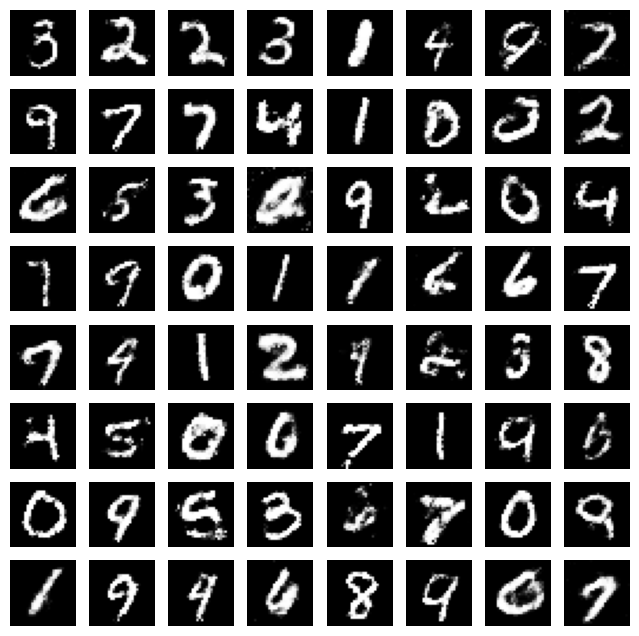

Epoch [71/100], Generator Loss: 2.9816226959228516, Critic Loss: -3.2485580444335938
Epoch [72/100], Generator Loss: 1.6800740957260132, Critic Loss: -2.745418071746826
Epoch [73/100], Generator Loss: -0.1189253106713295, Critic Loss: -2.539354085922241
Epoch [74/100], Generator Loss: 5.967062950134277, Critic Loss: -3.752396821975708
Epoch [75/100], Generator Loss: 4.321318626403809, Critic Loss: -2.9153096675872803
Epoch [76/100], Generator Loss: 3.5777316093444824, Critic Loss: -2.163239002227783
Epoch [77/100], Generator Loss: 5.760762691497803, Critic Loss: -3.2907581329345703
Epoch [78/100], Generator Loss: 0.5857945680618286, Critic Loss: -2.8113765716552734
Epoch [79/100], Generator Loss: 4.780290126800537, Critic Loss: -3.6820144653320312
Epoch [80/100], Generator Loss: 1.0657081604003906, Critic Loss: -3.443675994873047


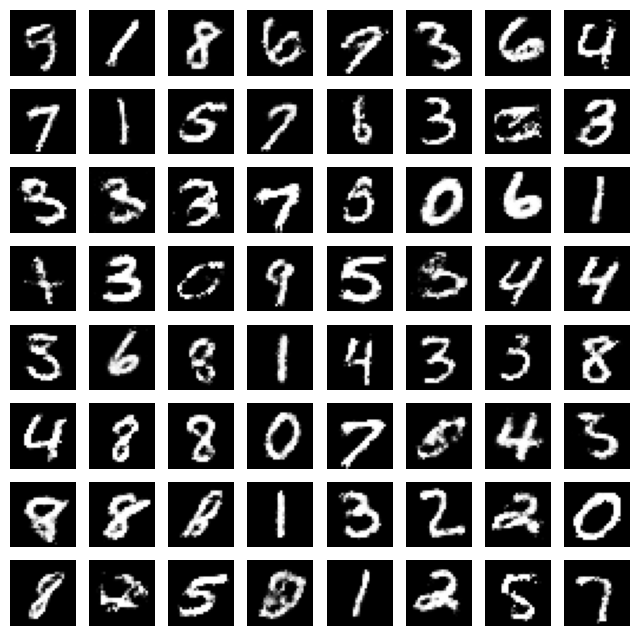

Epoch [81/100], Generator Loss: 1.3235647678375244, Critic Loss: -2.435992479324341
Epoch [82/100], Generator Loss: 3.1828856468200684, Critic Loss: -2.1605072021484375
Epoch [83/100], Generator Loss: 1.1532655954360962, Critic Loss: -3.2512917518615723
Epoch [84/100], Generator Loss: -0.14105379581451416, Critic Loss: -3.0744316577911377
Epoch [85/100], Generator Loss: 0.3871604800224304, Critic Loss: -2.6859934329986572
Epoch [86/100], Generator Loss: 2.545626163482666, Critic Loss: -2.996551990509033
Epoch [87/100], Generator Loss: 5.117160797119141, Critic Loss: -3.1218767166137695
Epoch [88/100], Generator Loss: 2.6230549812316895, Critic Loss: -2.5139174461364746
Epoch [89/100], Generator Loss: 0.5066891312599182, Critic Loss: -2.0322906970977783
Epoch [90/100], Generator Loss: 3.1051621437072754, Critic Loss: -3.561312675476074


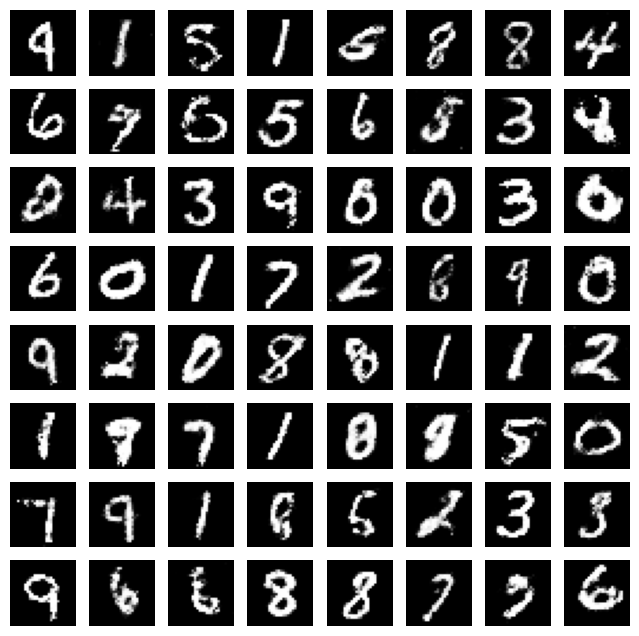

Epoch [91/100], Generator Loss: 2.7200472354888916, Critic Loss: -2.858132839202881
Epoch [92/100], Generator Loss: -0.2018950879573822, Critic Loss: -1.7165660858154297
Epoch [93/100], Generator Loss: 3.3968746662139893, Critic Loss: -2.2267708778381348
Epoch [94/100], Generator Loss: 1.6651740074157715, Critic Loss: -3.057025194168091
Epoch [95/100], Generator Loss: 1.1672803163528442, Critic Loss: -2.6467125415802
Epoch [96/100], Generator Loss: 4.5007476806640625, Critic Loss: -2.4921581745147705
Epoch [97/100], Generator Loss: 1.2615563869476318, Critic Loss: -2.62516188621521
Epoch [98/100], Generator Loss: 3.7443361282348633, Critic Loss: -2.680061101913452
Epoch [99/100], Generator Loss: 1.3585505485534668, Critic Loss: -2.983003616333008


In [ ]:
# Hyperparameters
z_dim = 100  # Latent vector size
lr = 0.00005  # Learning rate
n_critic = 5  # Number of critic updates per generator update
lambda_gp = 10  # Gradient penalty lambda

# Initialize models and optimizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

# Training Loop
epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)

            critic_real = critic(real_images)
            critic_fake = critic(fake_images)

            # Compute gradient penalty
            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)

            # Critic loss
            critic_loss = -torch.mean(critic_real) + torch.mean(critic_fake) + lambda_gp * gradient_penalty

            optim_critic.zero_grad()
            critic_loss.backward()
            optim_critic.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        critic_fake = critic(fake_images)

        # Generator loss
        gen_loss = -torch.mean(critic_fake)

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()

    print(f"Epoch [{epoch}/{epochs}], Generator Loss: {gen_loss.item()}, Critic Loss: {critic_loss.item()}")

    # Visualize generated images
    if epoch % 10 == 0:
        with torch.no_grad():
            test_z = torch.randn(64, z_dim).to(device)
            generated_images = generator(test_z)
            generated_images = generated_images.cpu().data
            generated_images = generated_images.view(64, 28, 28)

            plt.figure(figsize=(8, 8))
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.imshow(generated_images[i], cmap='gray')
                plt.axis('off')
            plt.show()
